In [1]:
# If in colab, upload routing_output.zip
!unzip /content/routing_output.zip

Archive:  /content/routing_output.zip
   creating: routing_output/
   creating: routing_output/olmoe/
  inflating: routing_output/routing.jpg  
   creating: routing_output/text/
   creating: routing_output/mistral/
  inflating: routing_output/routing_prob_distribution.png  
   creating: routing_output/olmoe/eid2token/
   creating: routing_output/olmoe/expert_counts/
  inflating: routing_output/text/wikipedia_texts.txt  
  inflating: routing_output/text/github_oss_with_stack_texts.txt  
  inflating: routing_output/text/c4_texts.txt  
  inflating: routing_output/text/b3g_texts.txt  
  inflating: routing_output/text/arxiv_texts.txt  
   creating: routing_output/mistral/eid2token/
   creating: routing_output/mistral/expert_counts/
  inflating: routing_output/olmoe/eid2token/book.pkl  
  inflating: routing_output/olmoe/eid2token/github.pkl  
  inflating: routing_output/olmoe/eid2token/wikipedia.pkl  
  inflating: routing_output/olmoe/eid2token/c4.pkl  
  inflating: routing_output/olmoe/eid2

In [2]:
!pip install -q git+https://github.com/Muennighoff/transformers.git@olmoe

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
# Get your key at https://wandb.ai/authorize
# Then use Colab secrets and set it under the name WANDB & then run this cell to login
# See https://github.com/wandb/wandb/issues/2074
from google.colab import userdata
token = userdata.get('HF') # or manually use your token

In [20]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from transformers import OlmoeForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("OLMoE/OLMoE-1B-7B-0924", token=token)


'''
read all dumped data
'''
def load_data(input_path):
    with open(input_path, 'rb') as f:
        data = pickle.load(f)
    return data


def print_expert_percentage(exp_counts):
    total = sum(exp_counts.values())
    for eid, ecount in exp_counts.most_common():
        print(f"Expert {eid}: {ecount/total*100:.2f}")

def convert_to_percentage(exp_counts):
    total = sum(exp_counts.values())
    return {eid: ecount/total*100 for eid, ecount in exp_counts.items()}

def token_to_count(counts_layer):
    token2count_all = Counter()
    for eid, token2count in counts_layer.items():
        token2count_all.update(token2count)
    return token2count_all


def convert_to_percentage_token2count(counts_layer, token2count_all, model):
    for eid, token2count in counts_layer.items():
        for token in token2count.copy():
            # print(token2count[token])
            # print(token2count_all[token])
            if token2count[token] < 8:
                del token2count[token]
            else:
                if model == "olmoe":
                    token2count[token] = token2count[token] / (token2count_all[token]/8)
                elif model == "mistral":
                    token2count[token] = token2count[token] / (token2count_all[token]/2)
    return counts_layer

model = "olmoe" # mistral
all_domains = ["github", "arxiv", "c4", "book", "wikipedia"]
data_layer0 = {}
data_layer7 = {}
data_layer15 = {}
eid2token_layer0 = {}
eid2token_layer7 = {}
eid2token_layer15 = {}
data_total_token2count = {}
for domain in all_domains:
    input_path = f"routing_output/{model}/expert_counts/{domain}.pkl"
    counts_layer0, counts_layer7, counts_layer15 = load_data(input_path)
    data_layer0[domain] = convert_to_percentage(counts_layer0)
    data_layer7[domain] = convert_to_percentage(counts_layer7)
    data_layer15[domain] = convert_to_percentage(counts_layer15)

    input_path = f"routing_output/{model}/eid2token/{domain}.pkl"
    counts_layer0, counts_layer7, counts_layer15 = load_data(input_path)
    token2count_all = token_to_count(counts_layer7)
    data_total_token2count[domain] = token2count_all
    # counts_layer = convert_to_percentage_token2count(counts_layer0, token2count_all)
    # eid2token_layer0[domain] = counts_layer0
    # eid2token_layer7[domain] = counts_layer7
    # eid2token_layer15[domain] = counts_layer15
    # convert_to_percentage_token2count(counts_layer0, token2count_all)
    # eid2token_layer7[domain] = convert_to_percentage_token2count(counts_layer7, token2count_all)
    eid2token_layer15[domain] = convert_to_percentage_token2count(counts_layer15, token2count_all, model)


In [21]:
'''
convert the data for plotting
'''
domain = "c4"

domain2rout_prob0 = {}
domain2rout_prob4 = {}
domain2rout_prob7 = {}

for domain in ["github", "arxiv", "c4", "book", "wikipedia"]:
    # use the layer 15th data
    for eid, token2count in eid2token_layer15[domain].items():
        # print("expert: ",eid)
        total_token2count = data_total_token2count[domain]
        token2count = token2count.most_common()
        '''
        this decides which expert you want to plot the distribution of
        For mistral, we use expert 0, 4, 7 for plotting
        '''
        if eid == 0:
            domain2rout_prob0[domain] = [p for (t, p) in token2count]
            # print(token2count)
        if eid == 4:
            domain2rout_prob4[domain] = [p for (t, p) in token2count]
        if eid == 7:
            domain2rout_prob7[domain] = [p for (t, p) in token2count]



<ipython-input-27-9745d81be588>:95: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.9, hspace=0.45)


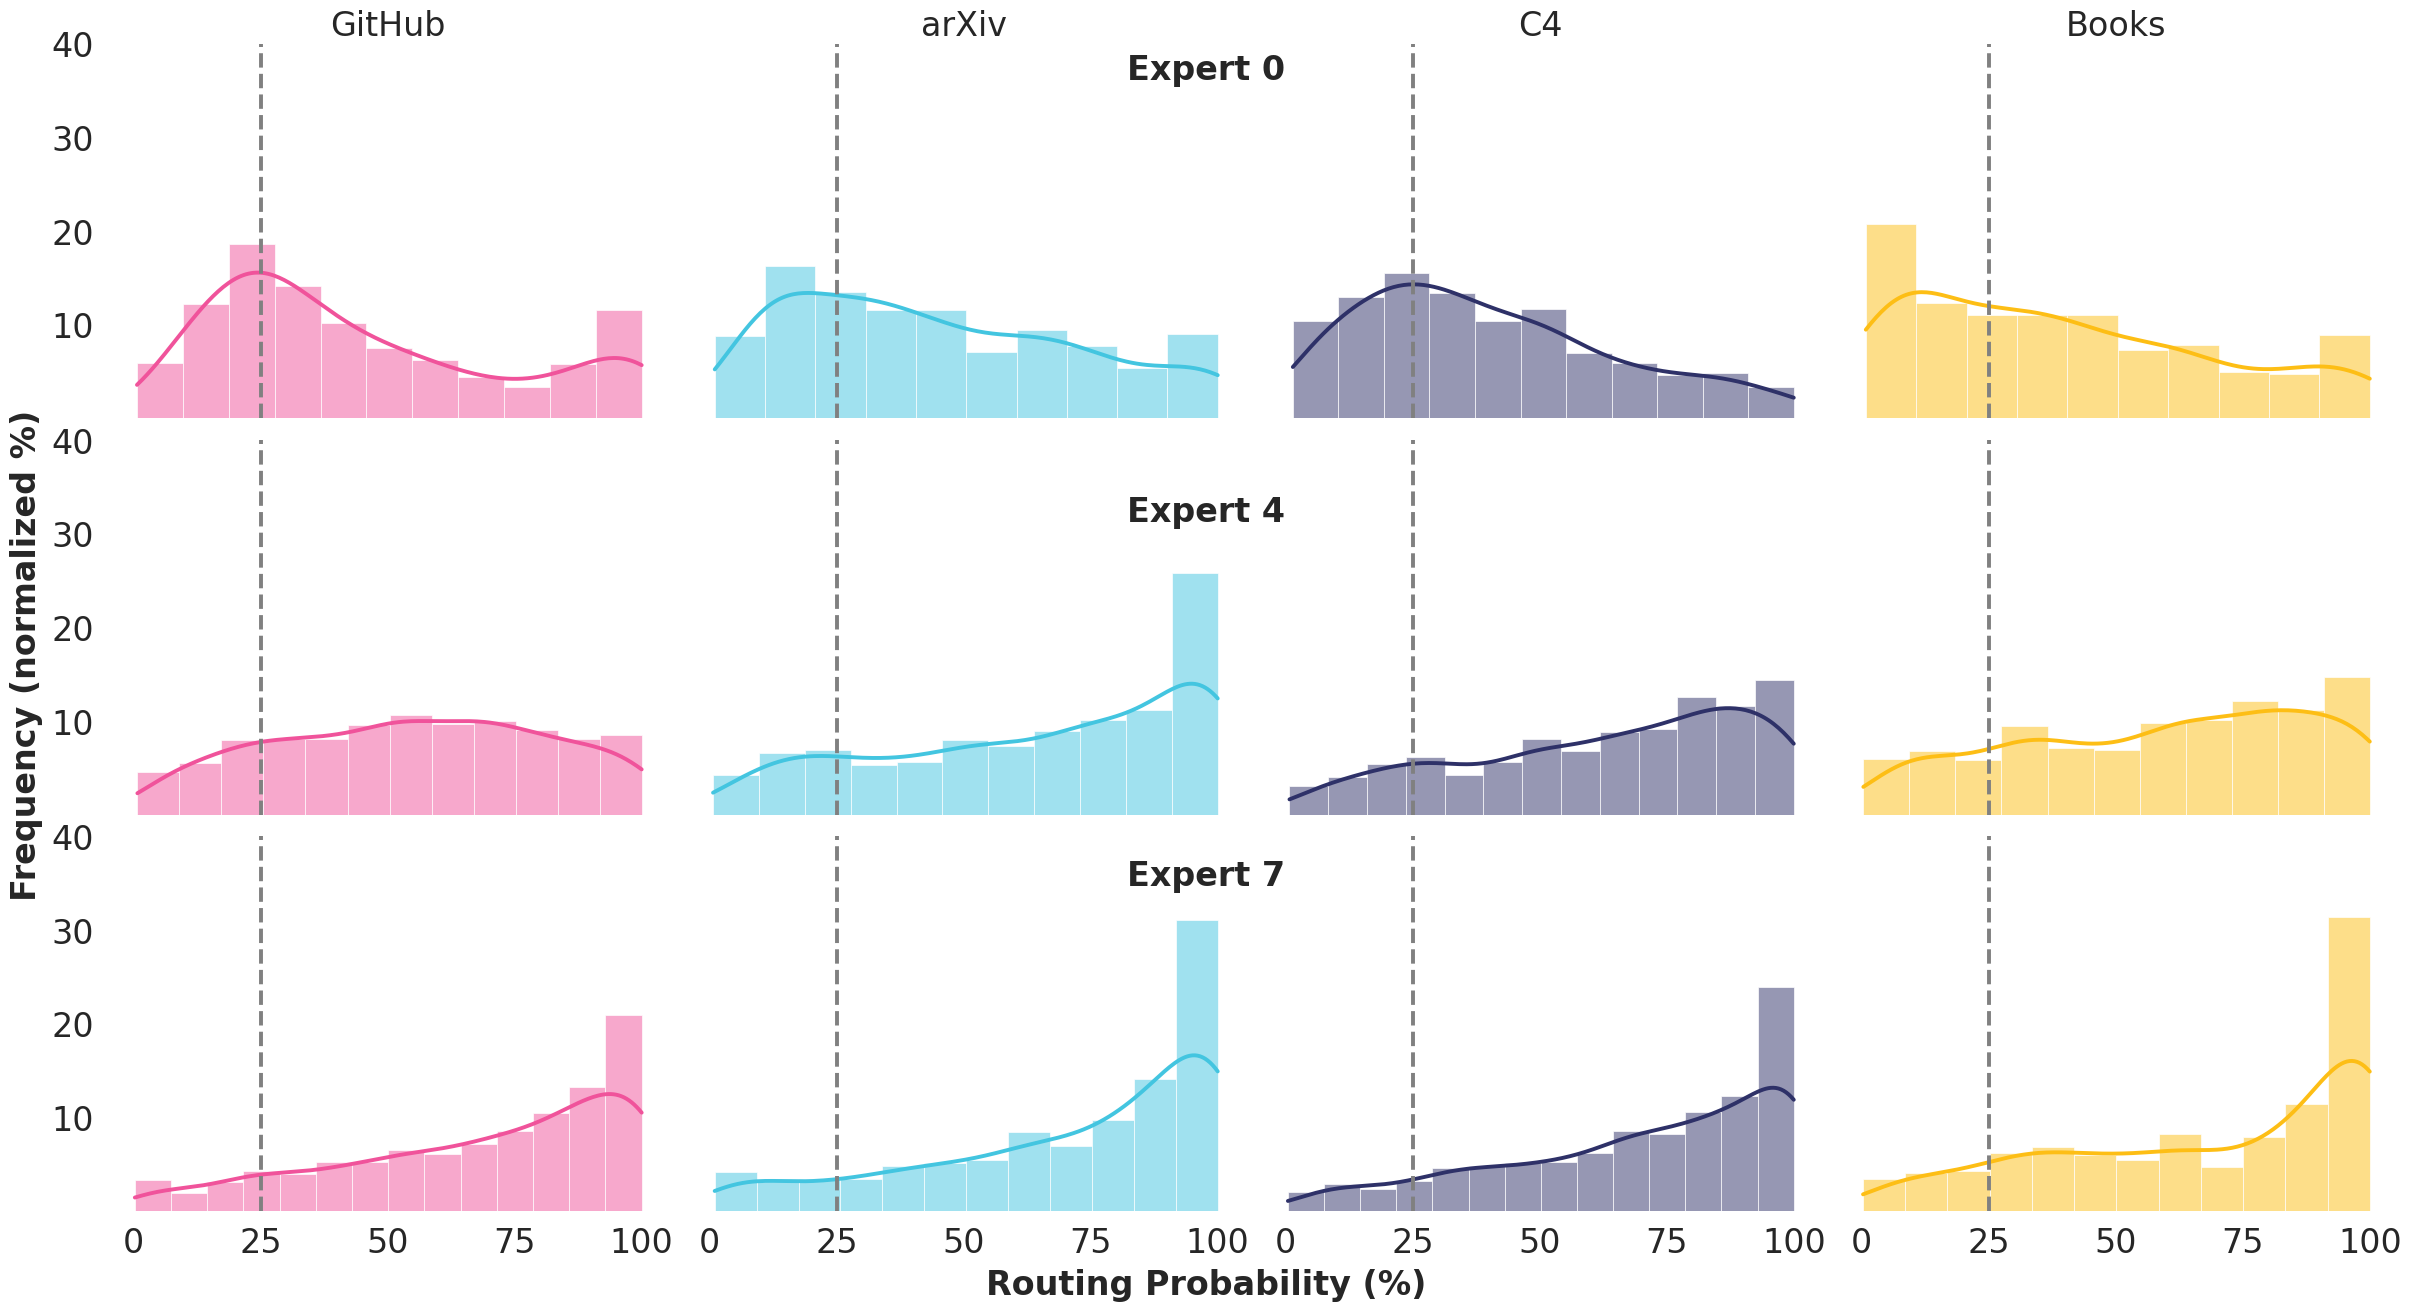

In [27]:
FONTSIZE = 24
# Custom color palette
custom_palette = {
    'github': '#F0539B',
    'arxiv': '#43C5E0',
    'c4': '#2E3168',
    'book': '#FDBE15',
    'wikipedia': '#FF6B6B',
}

# Create a figure with 3x4 subplots
fig, axes = plt.subplots(3, 4, figsize=(24, 13), sharex=True, sharey=True, layout='constrained')
# fig.suptitle('Routing Probability Distribution by Domain and Expert', fontsize=16, y=0.95)

'''
Note this experts and domains are hardcoded. It should match the expert number above
'''
# List of experts and domains
experts = [0, 4, 7]
domains = ["github", "arxiv", "c4", "book"] #  "wikipedia"
domain_to_title = {
    'github': 'GitHub',
    'arxiv': 'arXiv',
    'c4': 'C4',
    'book': 'Books',
    'wikipedia': 'Wikipedia',
}

# Iterate through experts and domains to create subplots
for row, expert in enumerate(experts):
    for col, domain in enumerate(domains):
        ax = axes[row, col]

        # Get the correct data based on the expert
        data = globals()[f'domain2rout_prob{expert}'][domain]

        # Multiply x and y data by 100 to convert to percentage
        data = np.array(data) * 100

        # # Plot histogram
        # sns.histplot(data, ax=ax, color=custom_palette[domain], kde=True, stat='probability')

        # Plotting the probability histogram
        # g = sns.histplot(data, ax=ax, color=custom_palette[domain], kde=True, stat='probability')
        g = sns.histplot(data, ax=ax, color=custom_palette[domain], kde=True, stat='percent')
        g.set(xlabel=None)
        g.set(ylabel=None)
        #ax.set_ylabel('Frequency (normalized)')

        # # Creating a twin axis to show counts
        # ax2 = ax.twinx()
        # sns.histplot(data, ax=ax2, color=custom_palette[domain], kde=False, stat='count')
        # ax2.set_ylabel('Frequency')
        # ax2.grid(False)  # Optionally turn off the grid for the secondary axis


        # Add mean line
        #ax.axvline(x=1/8, color='grey', linestyle='--')
        if model == "olmoe":
            ax.axvline(x=1/8*100, color='grey', linestyle='--')
        else:
            ax.axvline(x=2/8*100, color='grey', linestyle='--')
        ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)

        # Set labels and title
        # ax.set_xlabel('Routing Probability')
        # ax.set_ylabel('Frequency')

        # Set yticks
        ax.set_yticks([10, 20, 30, 40])

        # set the y-axis range
        #ax.set_ylim(0, 0.5)

        # Set title for top row only
        if row == 0:
            ax.set_title(domain_to_title[domain], fontsize=FONTSIZE)

        # Add legend
        if row == 0 and col == 0:  # Only add legend to the first plot
            ax.legend()

    # Add subtitle for each row
    if row == 0:
        fig.text(0.5, 0.95, f'Expert {expert}', ha='center', va='center', fontsize=FONTSIZE, fontweight='bold')
    else:
        fig.text(0.5, 0.89 - row*0.28, f'Expert {expert}', ha='center', va='center', fontsize=FONTSIZE, fontweight='bold')


fig.supxlabel('Routing Probability (%)', fontsize=FONTSIZE, fontweight='bold')
fig.supylabel('Frequency (normalized %)', fontsize=FONTSIZE, fontweight='bold')

# Adjust layout and display plot
# plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.45)
# plt.subplots_adjust(top=0.88, hspace=0.3, bottom=0.05)
# save the plot
plt.savefig("routing_output/routing_prob_distribution.png")
plt.show()


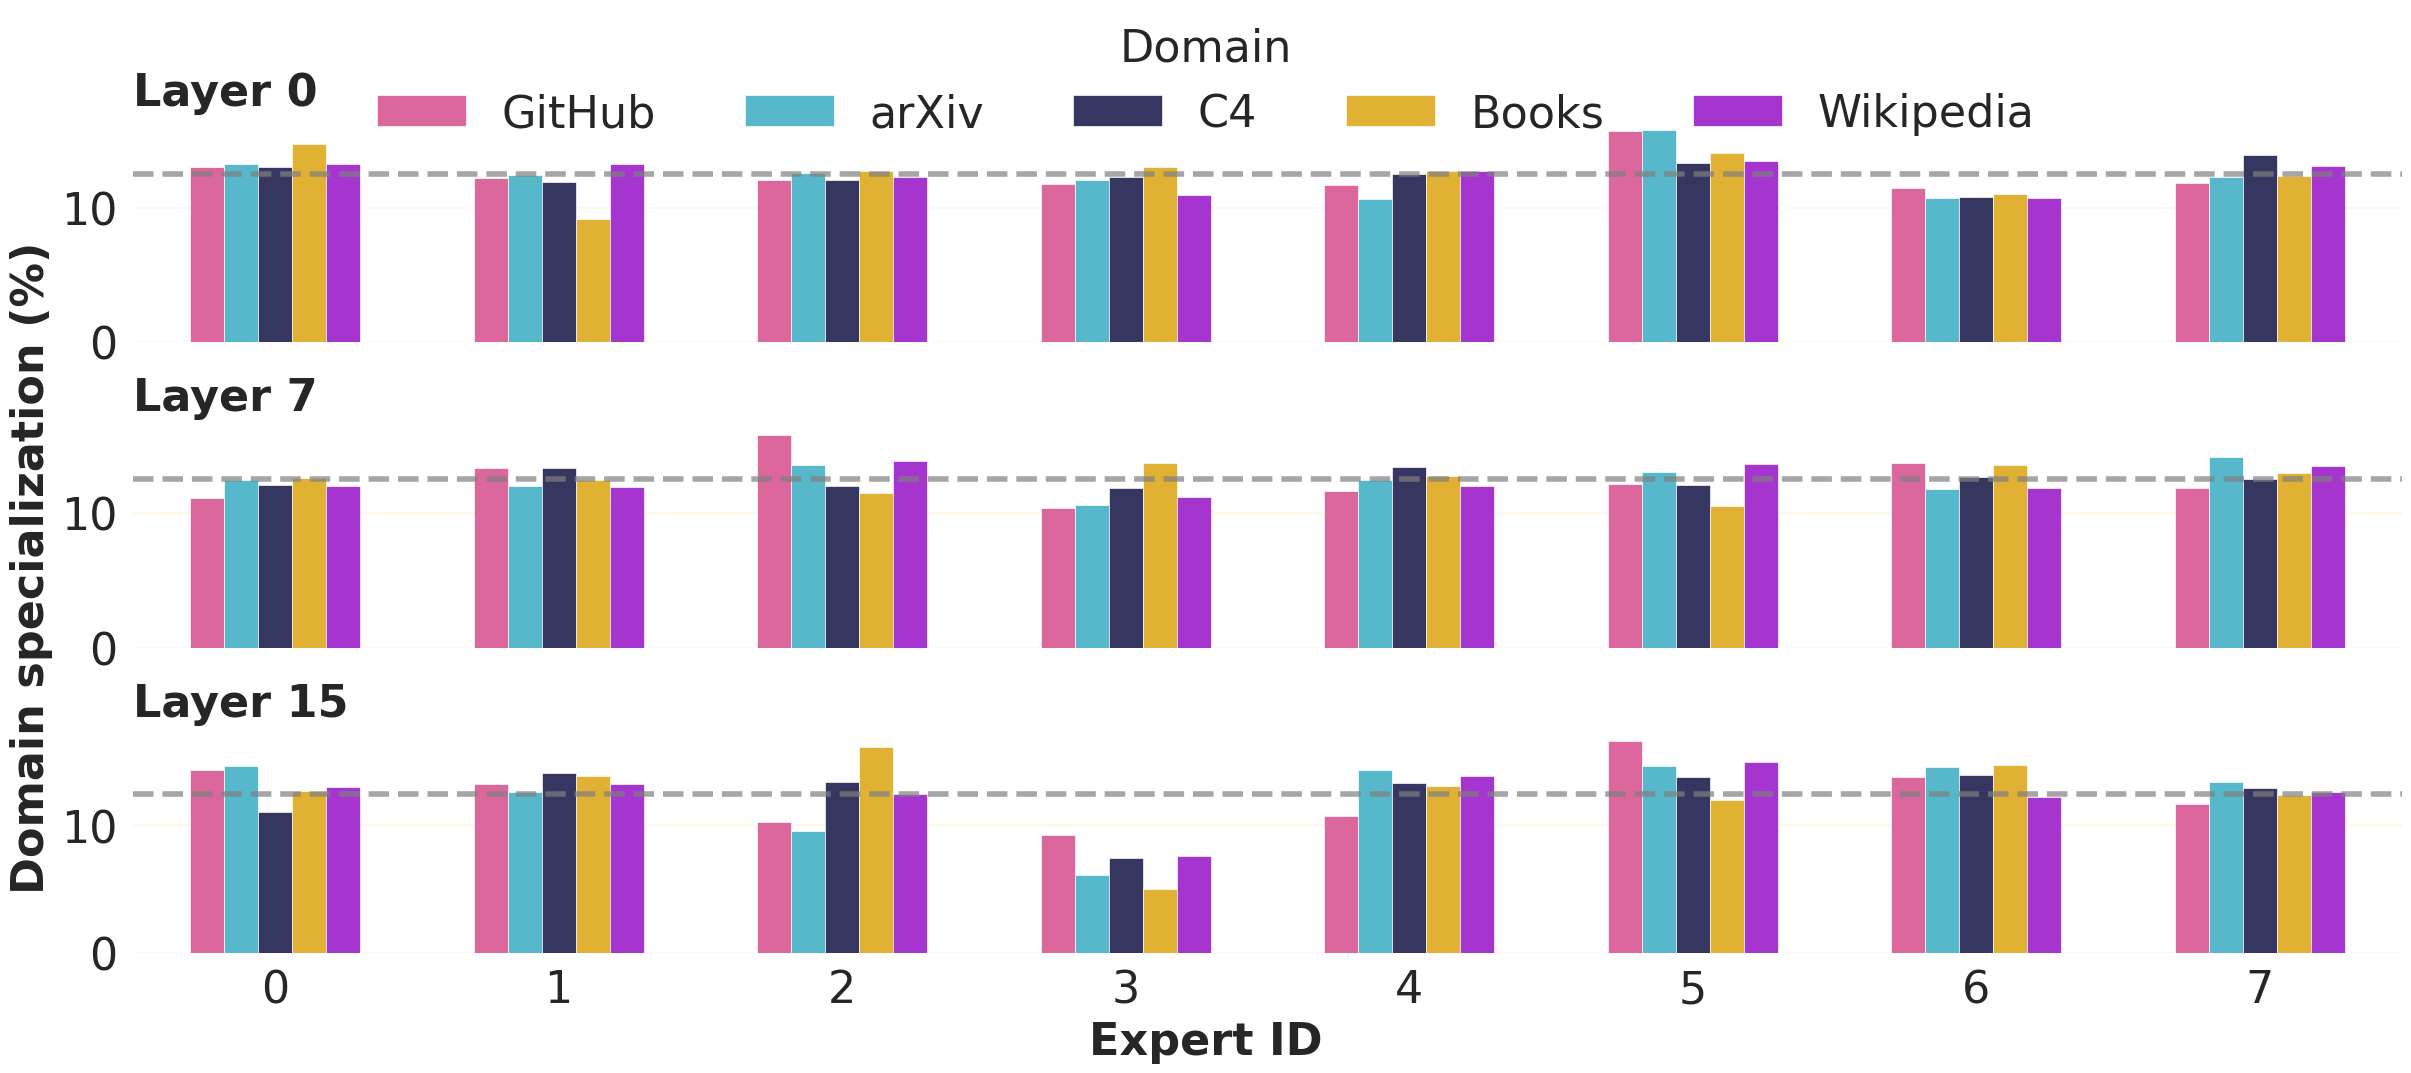

In [13]:
'''
Mistral plot
'''

custom_palette = {
    'GitHub': '#F0539B',
    'arXiv': '#43C5E0',
    'C4': '#2E3168',
    'Books': '#FDBE15',
    'Wikipedia': '#FF6B6B',
    'Wikipedia': '#B11BE8',
}

FONTSIZE = 32


# Function to prepare data
def prepare_data(data):
    df = pd.DataFrame(data)
    df = df.reset_index().melt(id_vars='index', var_name='Domain', value_name='Value')
    df = df.rename(columns={'index': 'Expert ID'})
    # Rename the domain names
    df['Domain'] = df['Domain'].map({'github': 'GitHub', 'arxiv': 'arXiv', 'c4': 'C4', 'book': 'Books', 'wikipedia': 'Wikipedia'})
    return df

# Function to create subplot
def create_subplot(ax, data, title):
    #sns.barplot(x='Expert ID', y='Value', hue='Domain', data=data, ax=ax, palette=custom_palette)
    b = sns.barplot(x='Expert ID', y='Value', hue='Domain', data=data, ax=ax, palette=custom_palette, width=0.6)

    b.set(xlabel=None)
    b.set(ylabel=None)
    # ax.axvline(y=1/8*100, color='grey', linestyle='--')
    # ax.axhline(y=1/64*100, color='grey', linestyle='--', linewidth=2, alpha=0.7)

    # ax.axhline(y=1/8*100, color='grey', linestyle='--', linewidth=2, alpha=0.7)
    ax.axhline(y=1/8*100, color='grey', linestyle='--', linewidth=4, alpha=0.7)
    ax.set_title(title, fontsize=FONTSIZE, pad=10, fontweight='bold', loc='left')

    #if title == 'Layer 15':
    #    ax.set_xlabel('Expert ID', fontsize=FONTSIZE, labelpad=5)
    #else:
    #    ax.set_xlabel('')
    #ax.set_ylabel('Selection proportion', fontsize=FONTSIZE, labelpad=5)
    # ax.set_facecolor('none')
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    # ax.set_ylim(0, 10)
    ax.set_axisbelow(True)
    # axis=
    ax.grid(True, axis='y', linestyle='-', alpha=0.3, color='#FFE5B4')
    # ax.legend(loc='upper right', title='Domain', title_fontsize='12', fontsize='10')
    # ax.tick_params(axis='x', rotation=45, ha='right')

# Set up the plot style
plt.style.use('seaborn-v0_8-poster')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_style("white")

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 10), sharex=True, layout='constrained')
fig.patch.set_facecolor('none')

# Prepare data for each layer
df_layer0 = prepare_data(data_layer0)
df_layer7 = prepare_data(data_layer7)
df_layer15 = prepare_data(data_layer15)

# Create subplots
create_subplot(ax1, df_layer0, 'Layer 0')
create_subplot(ax2, df_layer7, 'Layer 7')
create_subplot(ax3, df_layer15, 'Layer 15')

# Adjust layout
# plt.tight_layout()

# Create a single legend for the entire figure
handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, title='Domain', loc='upper center', title_fontsize=FONTSIZE, fontsize=FONTSIZE, ncol=len(labels), bbox_to_anchor=(0.5, 1.08))

# fig.supylabel('Selection proportion (%)', fontsize=FONTSIZE, fontweight='bold')
fig.supylabel('Domain specialization (%)', fontsize=FONTSIZE, fontweight='bold')
fig.supxlabel('Expert ID', fontsize=FONTSIZE, fontweight='bold')

# Title
#ax1.set_title("Mixtral-8x7B", fontsize=FONTSIZE, fontweight='bold')
#plt.subplots_adjust(top=0.9)#, hspace=0.45)

# Remove individual legends from subplots
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()

# Show the plot
plt.savefig('routing_mixtral.jpg', format='jpg', bbox_inches='tight')
plt.savefig('routing_mixtral.pdf', bbox_inches='tight')
plt.show()

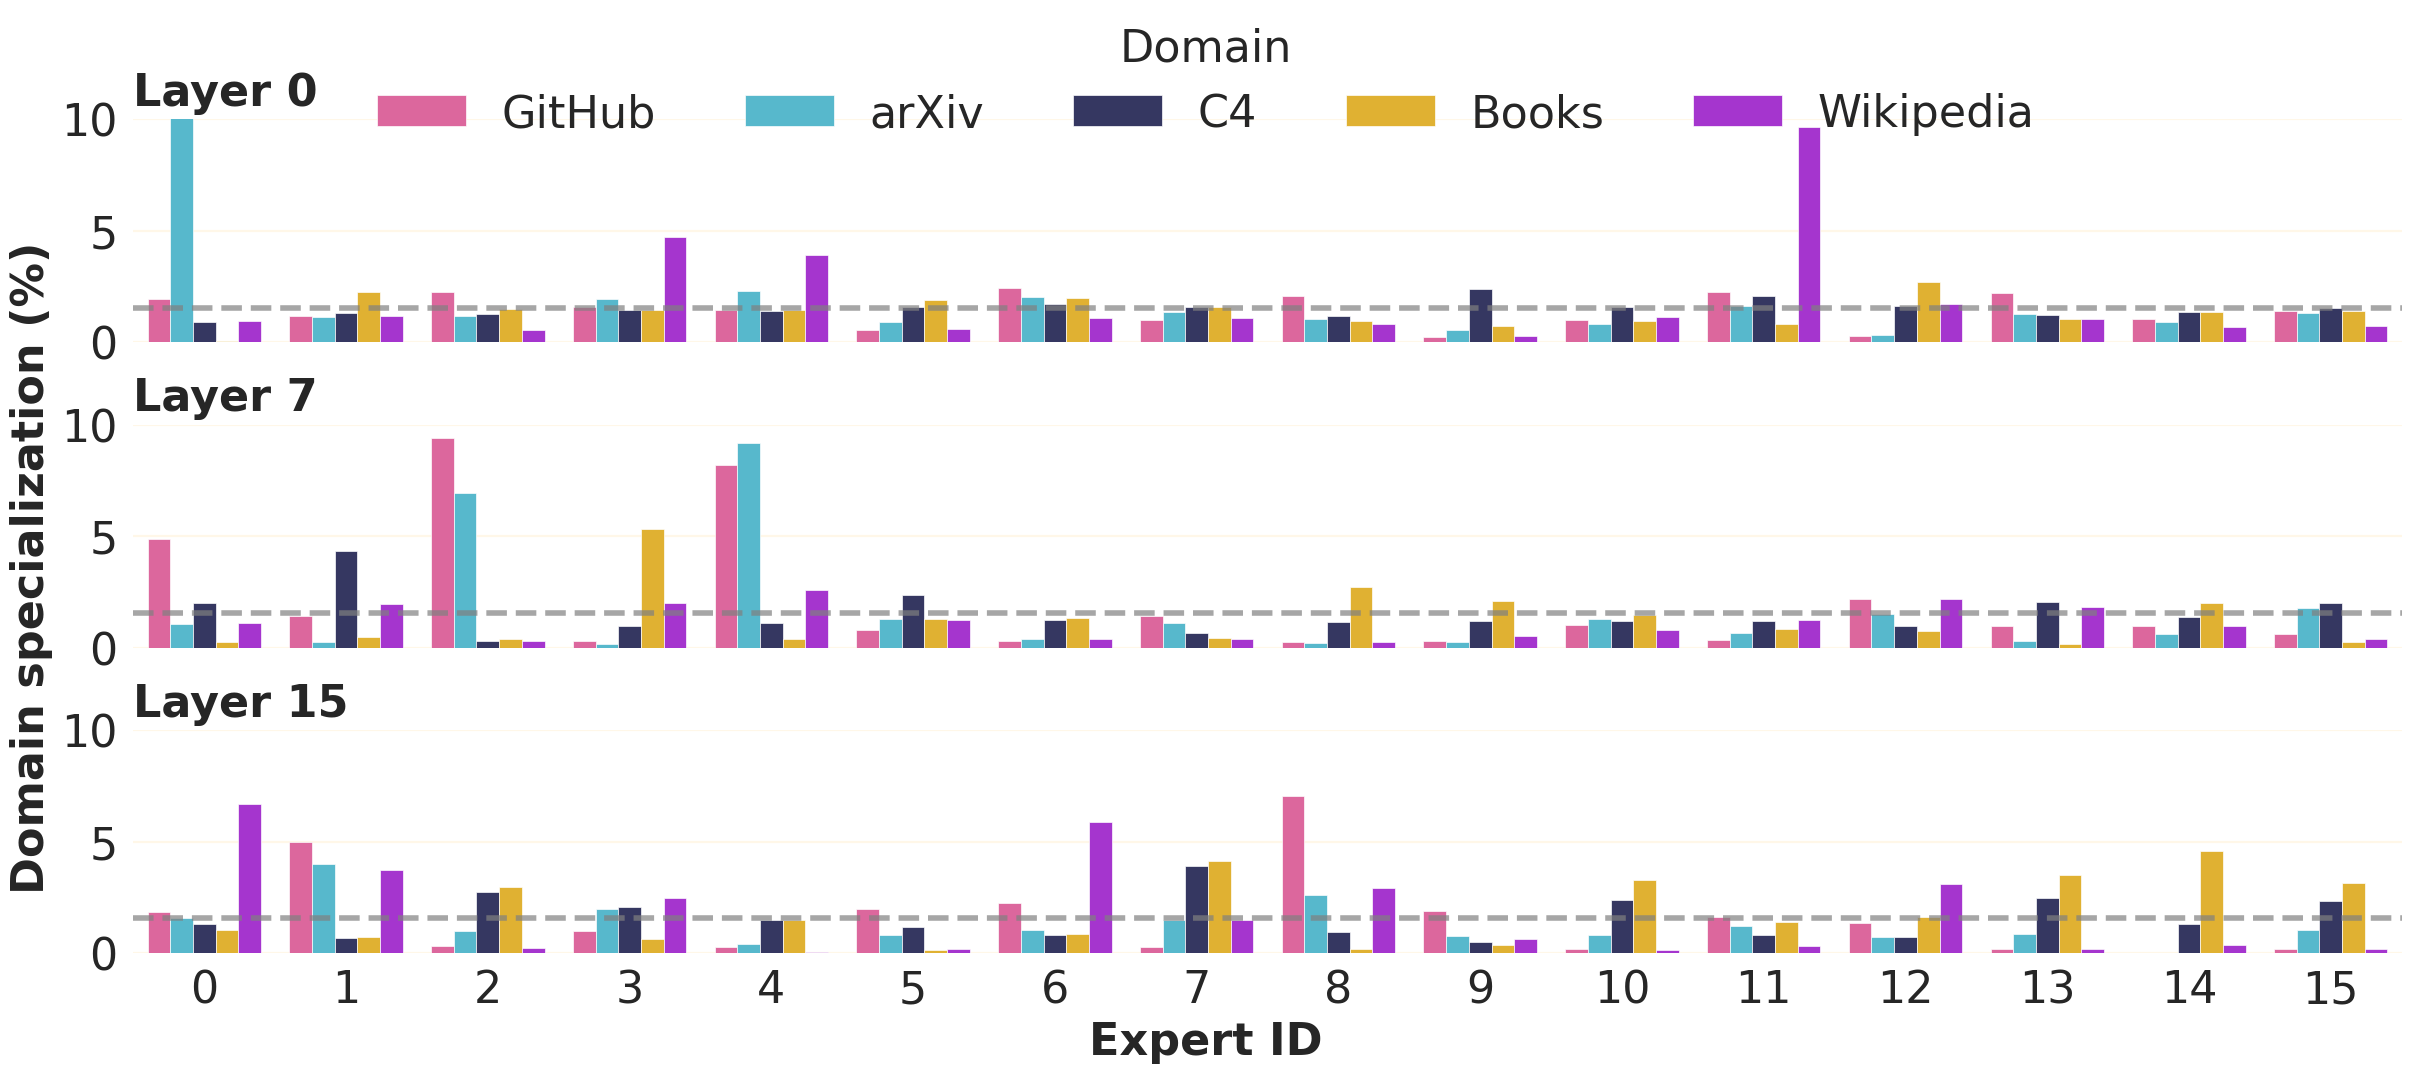

In [9]:
'''
Olmoe
'''
from collections import defaultdict
custom_palette = {
    'github': '#F0539B',
    'arxiv': '#43C5E0',
    'c4': '#2E3168',
    'book': '#FDBE15',
    'wikipedia': '#FF6B6B',
}

custom_palette = {
    'GitHub': '#F0539B',
    'arXiv': '#43C5E0',
    'C4': '#2E3168',
    'Books': '#FDBE15',
    #'Wikipedia': '#FF6B6B',
    #'Wikipedia': '#0FCB8C',
    #'Wikipedia': '#105257',
    #'Wikipedia': '#FAF2E9',
    'Wikipedia': '#B11BE8',
}

FONTSIZE = 32


# Function to prepare data
def prepare_data(data):
    df = pd.DataFrame(data)
    df = df.reset_index().melt(id_vars='index', var_name='Domain', value_name='Value')
    df = df.rename(columns={'index': 'Expert ID'})
    # Rename the domain names
    df['Domain'] = df['Domain'].map({'github': 'GitHub', 'arxiv': 'arXiv', 'c4': 'C4', 'book': 'Books', 'wikipedia': 'Wikipedia'})
    return df

# Function to create subplot
def create_subplot(ax, data, title):
    #sns.barplot(x='Expert ID', y='Value', hue='Domain', data=data, ax=ax, palette=custom_palette)
    b = sns.barplot(x='Expert ID', y='Value', hue='Domain', data=data, ax=ax, palette=custom_palette)
    b.set(xlabel=None)
    b.set(ylabel=None)
    #ax.axhline(y=1/64*100, color='grey', linestyle='--', linewidth=2, alpha=0.7)
    ax.axhline(y=1/64*100, color='grey', linestyle='--', linewidth=4, alpha=0.7)
    ax.set_title(title, fontsize=FONTSIZE, pad=10, fontweight='bold', loc='left')


    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    ax.set_ylim(0, 10)
    ax.set_axisbelow(True)
    # axis=
    ax.grid(True, axis='y', linestyle='-', alpha=0.3, color='#FFE5B4')
    # ax.legend(loc='upper right', title='Domain', title_fontsize='12', fontsize='10')
    # ax.tick_params(axis='x', rotation=45, ha='right')

def select_first_16(data_layer0):
    data_layer0_new = defaultdict(dict)
    for domain in data_layer0.keys():
        for eid, token2count in data_layer0[domain].items():
            if eid > 15:
                continue
            else:
                data_layer0_new[domain][eid] = token2count
    return data_layer0_new

# Set up the plot style
plt.style.use('seaborn-v0_8-poster')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_style("white")

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 10), sharex=True, layout='constrained')
fig.patch.set_facecolor('none')

# Prepare data for each layer
data_layer0 = select_first_16(data_layer0)
data_layer7 = select_first_16(data_layer7)
data_layer15 = select_first_16(data_layer15)

df_layer0 = prepare_data(data_layer0)
df_layer7 = prepare_data(data_layer7)
df_layer15 = prepare_data(data_layer15)

# Create subplots
create_subplot(ax1, df_layer0, 'Layer 0')
create_subplot(ax2, df_layer7, 'Layer 7')
create_subplot(ax3, df_layer15, 'Layer 15')

# Adjust layout
# plt.tight_layout()

# Create a single legend for the entire figure
handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, title='Domain', loc='upper center', title_fontsize=FONTSIZE, fontsize=FONTSIZE, ncol=len(labels), bbox_to_anchor=(0.5, 1.08))

#fig.supylabel('Selection proportion (%)', fontsize=FONTSIZE, fontweight='bold')
fig.supylabel('Domain specialization (%)', fontsize=FONTSIZE, fontweight='bold')
fig.supxlabel('Expert ID', fontsize=FONTSIZE, fontweight='bold')

# Remove individual legends from subplots
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()

# Show the plot
plt.savefig('routing_olmoe.jpg', format='jpg', bbox_inches='tight')
plt.savefig('routing_olmoe.pdf', bbox_inches='tight')
plt.show()

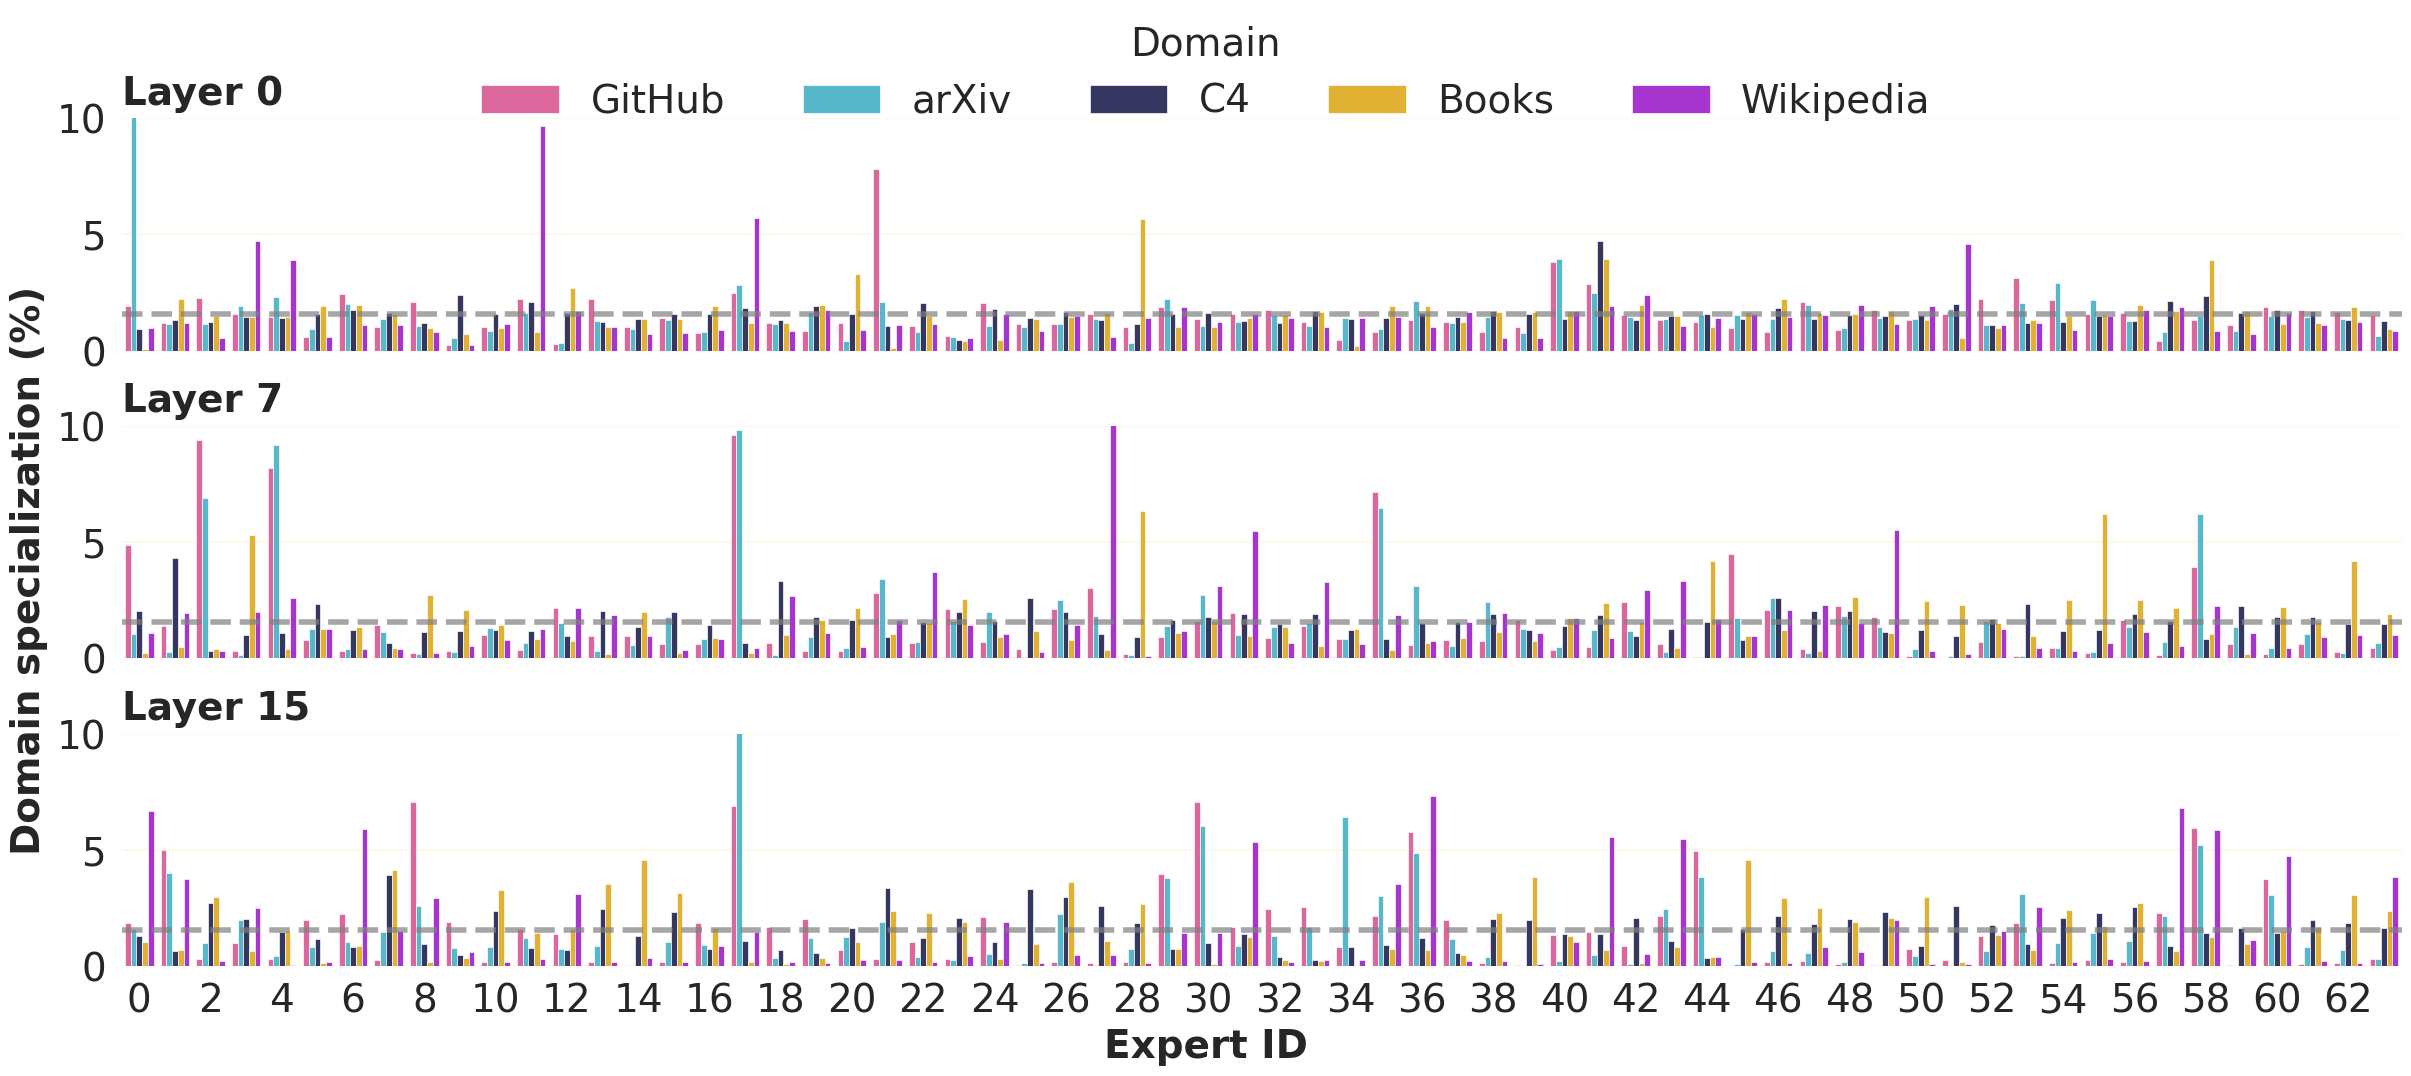

In [22]:
'''
olmoe: the entire plot.
'''

custom_palette = {
    'github': '#F0539B',
    'arxiv': '#43C5E0',
    'c4': '#2E3168',
    'book': '#FDBE15',
    'wikipedia': '#FF6B6B',
}

custom_palette = {
    'GitHub': '#F0539B',
    'arXiv': '#43C5E0',
    'C4': '#2E3168',
    'Books': '#FDBE15',
    'Wikipedia': '#FF6B6B',
    'Wikipedia': '#B11BE8',
}

FONTSIZE = 28

# Function to prepare data
def prepare_data(data):
    df = pd.DataFrame(data)
    df = df.reset_index().melt(id_vars='index', var_name='Domain', value_name='Value')
    df = df.rename(columns={'index': 'Expert ID'})
    # Rename the domain names
    df['Domain'] = df['Domain'].map({'github': 'GitHub', 'arxiv': 'arXiv', 'c4': 'C4', 'book': 'Books', 'wikipedia': 'Wikipedia'})
    return df

# Function to create subplot
def create_subplot(ax, data, title):
    # sns.barplot(x='Expert ID', y='Value', hue='Domain', data=data, ax=ax, palette=custom_palette)
    b = sns.barplot(x='Expert ID', y='Value', hue='Domain', data=data, ax=ax, palette=custom_palette)
    b.set(xlabel=None)
    b.set(ylabel=None)

    #ax.axhline(y=1/64*100, color='grey', linestyle='--', linewidth=2, alpha=0.7)
    ax.axhline(y=1/64*100, color='grey', linestyle='--', linewidth=4, alpha=0.7)
    # ax.set_title(title, fontsize=FONTSIZE, pad=10, fontweight='bold')
    ax.set_title(title, fontsize=FONTSIZE, pad=10, fontweight='bold', loc='left')


    #ax.set_xlabel('Expert ID', fontsize=FONTSIZE, labelpad=5)
    # ax.set_ylabel('Selection proportion', fontsize=15, labelpad=5)
    #ax.set_ylabel('Domain specialization (%)', fontsize=FONTSIZE, labelpad=5)
    # ax.set_facecolor('none')
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    ax.set_ylim(0, 10)
    ax.set_axisbelow(True)
    # axis=
    ax.grid(True, axis='y', linestyle='-', alpha=0.3, color='#FFE5B4')
    # ax.legend(loc='upper right', title='Domain', title_fontsize='12', fontsize='10')
    # ax.tick_params(axis='x', rotation=45, ha='right')

# Set up the plot style
plt.style.use('seaborn-v0_8-poster')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_style("white")

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 10), sharex=True, layout='constrained')
fig.patch.set_facecolor('none')

# Prepare data for each layer
df_layer0 = prepare_data(data_layer0)
df_layer7 = prepare_data(data_layer7)
df_layer15 = prepare_data(data_layer15)

# Create subplots
create_subplot(ax1, df_layer0, 'Layer 0')
create_subplot(ax2, df_layer7, 'Layer 7')
create_subplot(ax3, df_layer15, 'Layer 15')

# Adjust layout
#plt.tight_layout()

# Create a single legend for the entire figure
handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, title='Domain', loc='upper center', title_fontsize=FONTSIZE, fontsize=FONTSIZE, ncol=len(labels), bbox_to_anchor=(0.5, 1.08))

# Remove individual legends from subplots
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()

# Set x ticks
ticks = ax3.get_xticks()
ax3.set_xticks(ticks[::2])

#fig.supylabel('Selection proportion (%)', fontsize=FONTSIZE, fontweight='bold')
fig.supylabel('Domain specialization (%)', fontsize=FONTSIZE, fontweight='bold')
fig.supxlabel('Expert ID', fontsize=FONTSIZE, fontweight='bold')

# Show the plot
plt.savefig('routing_olmoe64.jpg', format='jpg', bbox_inches='tight')
plt.savefig('routing_olmoe64.pdf', bbox_inches='tight')
plt.show()

<ipython-input-39-6d86b1b8c235>:97: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.9, hspace=0.45)


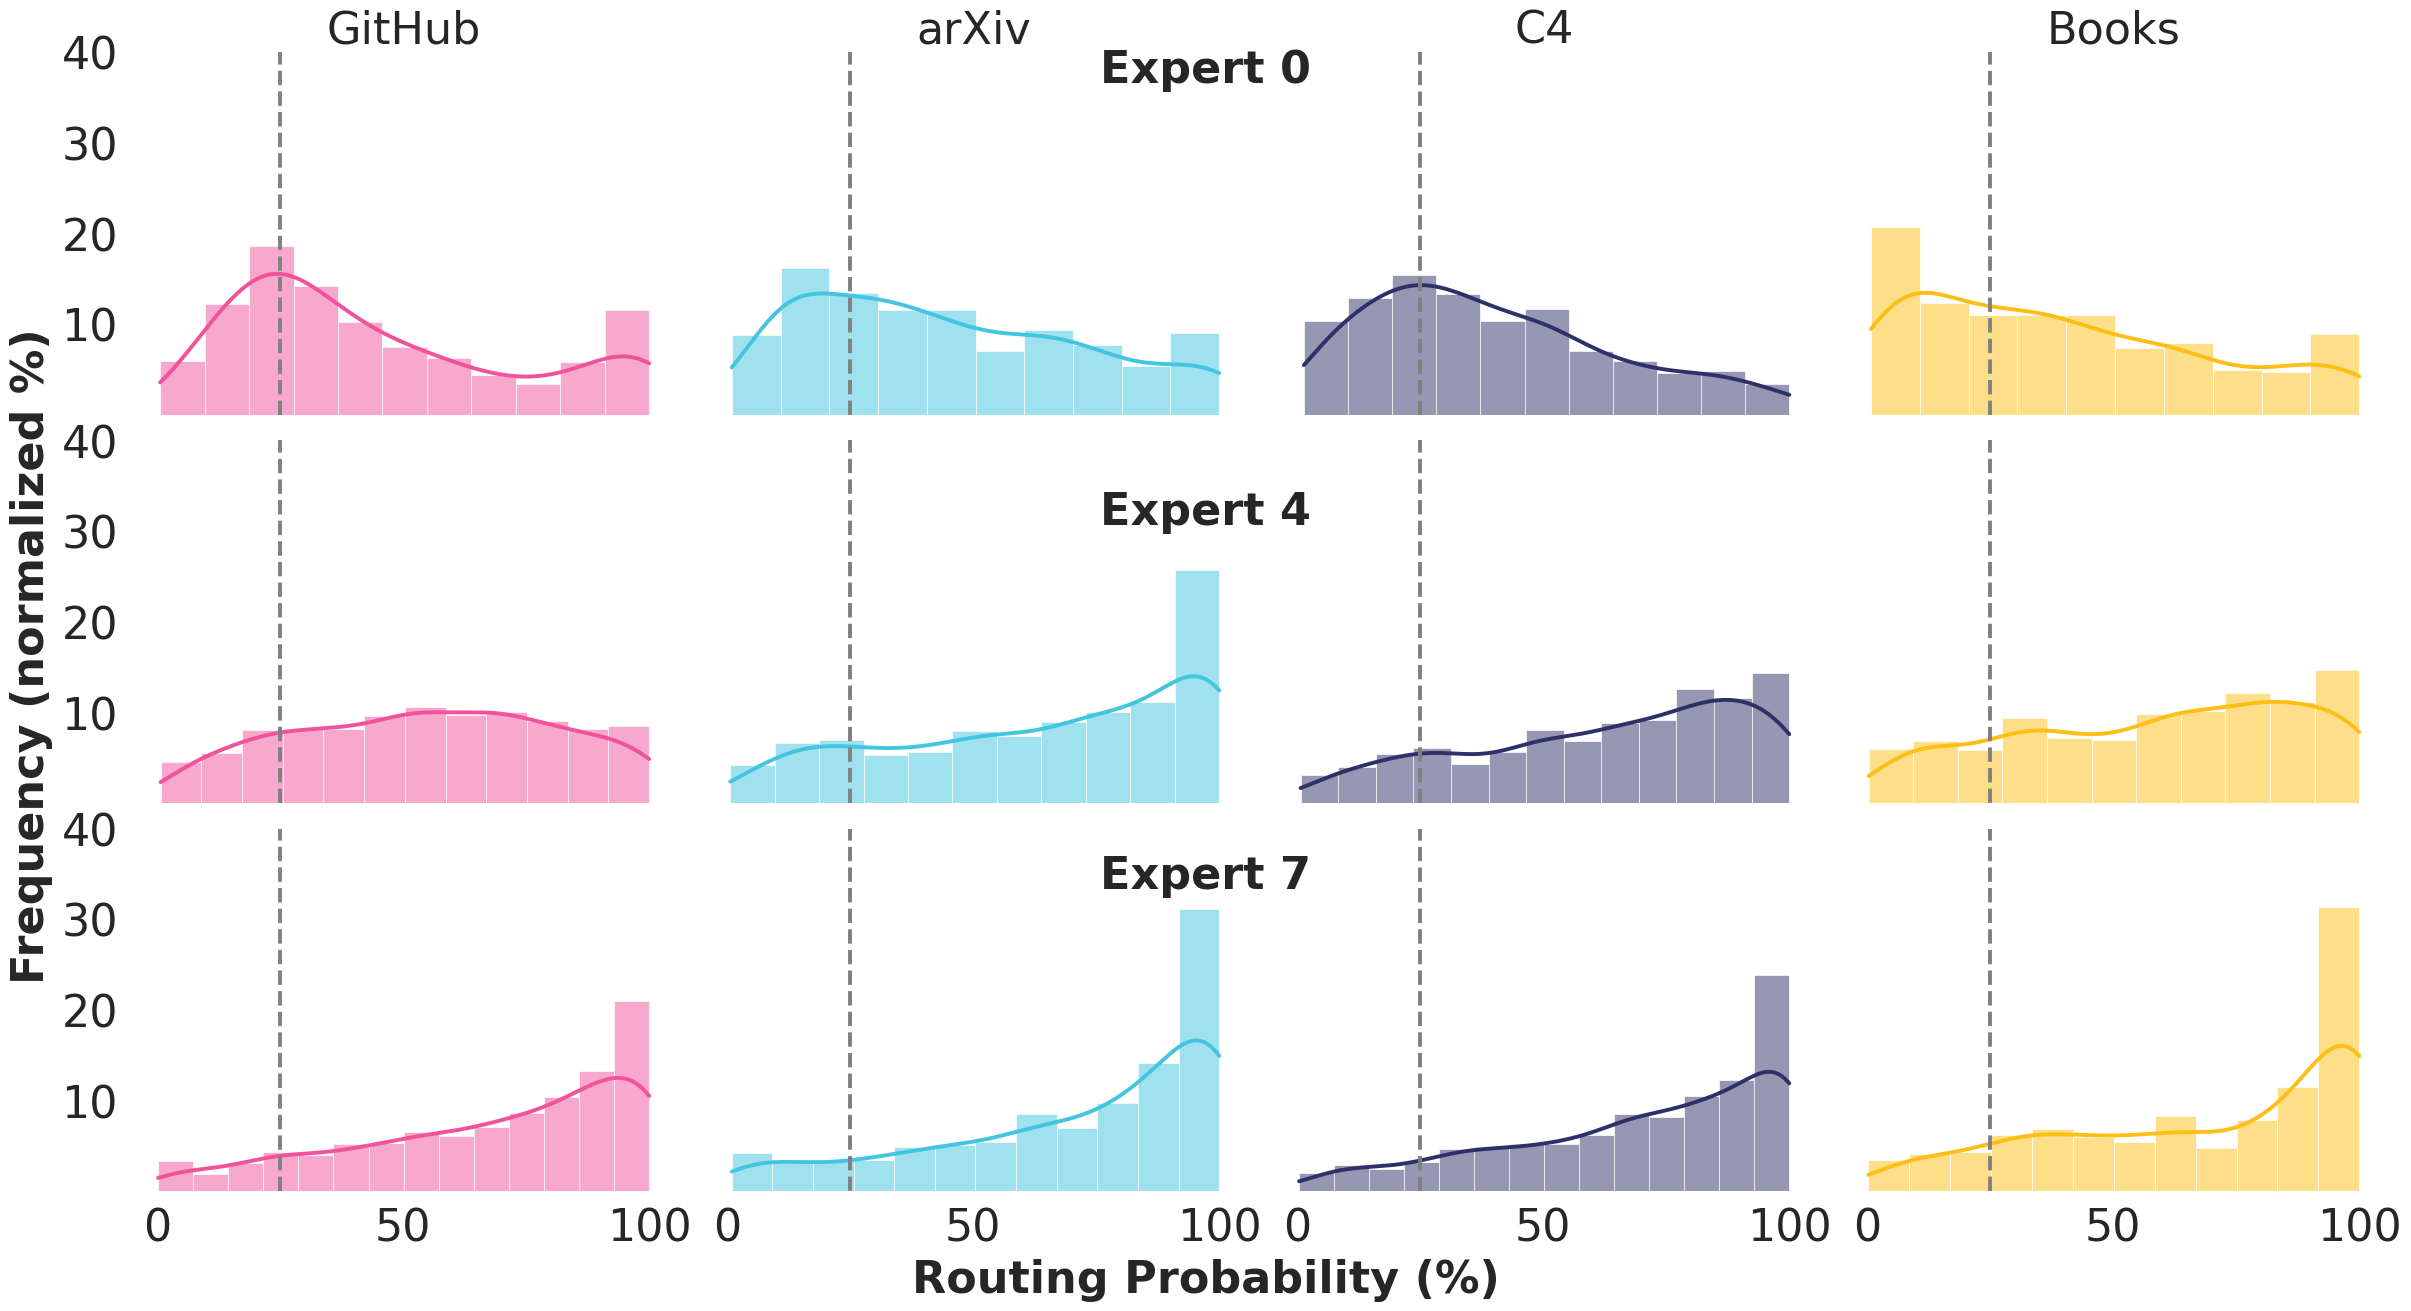

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

FONTSIZE = 32

# Custom color palette
custom_palette = {
    'github': '#F0539B',
    'arxiv': '#43C5E0',
    'c4': '#2E3168',
    'book': '#FDBE15',
    'wikipedia': '#FF6B6B',
}

# Create a figure with 3x4 subplots
fig, axes = plt.subplots(3, 4, figsize=(24, 13), sharex=True, sharey=True, layout='constrained')
# fig.suptitle('Routing Probability Distribution by Domain and Expert', fontsize=16, y=0.95)

# List of experts and domains
experts = [0, 4, 7]
domains = ["github", "arxiv", "c4", "book"] #  "wikipedia"
domain_to_title = {
    'github': 'GitHub',
    'arxiv': 'arXiv',
    'c4': 'C4',
    'book': 'Books',
    'wikipedia': 'Wikipedia',
}

# Iterate through experts and domains to create subplots
for row, expert in enumerate(experts):
    for col, domain in enumerate(domains):
        ax = axes[row, col]

        # Get the correct data based on the expert
        data = globals()[f'domain2rout_prob{expert}'][domain]

        # Multiply x and y data by 100 to convert to percentage
        data = np.array(data) * 100

        # # Plot histogram
        # sns.histplot(data, ax=ax, color=custom_palette[domain], kde=True, stat='probability')

        # Plotting the probability histogram
        # g = sns.histplot(data, ax=ax, color=custom_palette[domain], kde=True, stat='probability')
        g = sns.histplot(data, ax=ax, color=custom_palette[domain], kde=True, stat='percent')
        g.set(xlabel=None)
        g.set(ylabel=None)
        #ax.set_ylabel('Frequency (normalized)')

        # # Creating a twin axis to show counts
        # ax2 = ax.twinx()
        # sns.histplot(data, ax=ax2, color=custom_palette[domain], kde=False, stat='count')
        # ax2.set_ylabel('Frequency')
        # ax2.grid(False)  # Optionally turn off the grid for the secondary axis


        # Add mean line
        #ax.axvline(x=1/8, color='grey', linestyle='--')
        if model == "olmoe":
            ax.axvline(x=1/8*100, color='grey', linestyle='--')
        else:
            ax.axvline(x=2/8*100, color='grey', linestyle='--')
        ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)

        # Set labels and title
        # ax.set_xlabel('Routing Probability')
        # ax.set_ylabel('Frequency')

        # Set yticks
        ax.set_yticks([10, 20, 30, 40])

        # set the y-axis range
        #ax.set_ylim(0, 0.5)

        # Set title for top row only
        if row == 0:
            ax.set_title(domain_to_title[domain], fontsize=FONTSIZE)

        # Add legend
        if row == 0 and col == 0:  # Only add legend to the first plot
            ax.legend()

    # Add subtitle for each row
    if row == 0:
        fig.text(0.5, 0.95, f'Expert {expert}', ha='center', va='center', fontsize=FONTSIZE, fontweight='bold')
    else:
        fig.text(0.5, 0.89 - row*0.28, f'Expert {expert}', ha='center', va='center', fontsize=FONTSIZE, fontweight='bold')


fig.supxlabel('Routing Probability (%)', fontsize=FONTSIZE, fontweight='bold')
fig.supylabel('Frequency (normalized %)', fontsize=FONTSIZE, fontweight='bold')

# Adjust layout and display plot
# plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.45)
# plt.subplots_adjust(top=0.88, hspace=0.3, bottom=0.05)
# save the plot
plt.savefig("routing_prob_distribution.png")
plt.savefig("routing_prob_distribution.pdf")
plt.show()